# Doordash Assignment Part 1

## Overview

In this exercise, you will use your machine learning experience to solve a straightforward but challenging
prediction problem. The exercise contains two parts

1. Building a machine learning model for a prediction task
2. Writing an application to make predictions using that model.

In Part 1, we would love to have you exhibit your modelling skills. You will be evaluated on the following - performance on the test set, feature engineering choices including features used and encoding of features, data processing, choice of models used, description of model performance, and insights and observations from the model.

## Problem Description

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for
DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a
model to predict the estimated time taken for delivery and write an application that can make these
predictions.
Concretely, for a given delivery you must predict the total delivery duration of seconds , i.e., the time taken
from
Start: the time consumer submits the order (`created_at`) to
End: when the order will be delivered to the consumer (`actual_delivery_time`).
To help with this, we have provided

- historical_data.csv: table of historical deliveries
- data_to_predict.json : Json list of deliveries that you must predict on (for the second part)

## Requirements

- Build a model to predict the total delivery duration seconds (as defined above). Feel free to generate additional features from the given data to improve model performance.
- Explain a) model(s) used, b) how you evaluated your model performance on the historical data, c) any data processing you performed on the data, d) feature engineering choices you made and e) other information you would like us to know about your modeling approach.
- Based on the findings from the model, list recommendations to reduce delivery time.

## Deliverables

- Submit one document that includes a write-up explaining your model, choices made and discussion on the questions above.
- Submit the code used for this part.

## Notes

We expect the exercise to take 5-6 hours in total, but feel free to spend as much time as you like on it. Feel free
to use any open source packages for the task.

# Doordash Assignment Part 1 Solution

It is a regression task, as explained in the problem description. We will start with data exploration as we always do. Then, continue with investigating features for data preprocessing. Finally, we move to the modeling part. In the modeling part, we will examine the performance of different techniques. Let's begin!

# Data Exploration

We start with importing necessary libraries for data exploration and visualization. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set random seed to have reproducible results
# sklearn uses numpy random seed
np.random.seed(42)

Read the data from given file (`historical_data.csv`).

In [112]:
historical_data = pd.read_csv("historical_data.csv")
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


Check the column data types and non-null count through _dataframe.info( )_.

In [113]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

We see some id columns in the dataframe, which are generally not useful in prediction tasks. The dataset includes null values which we will deal with at some point within data preprocessing. Most importantly, there is no column in the dataset that represents our target value (the value that we will predict) explicitly. We can deduce it by using the difference between `created_at` and `actual_delivery_time`. To do that, we first convert the columns to DateTime data type. Then, we obtain the time in terms of seconds through _.dt.total_seconds( )_. We can use the calculated value as our target in regression.

In [114]:
from datetime import datetime 
historical_data["created_at"] = pd.to_datetime(historical_data['created_at'])
historical_data["actual_delivery_time"] = pd.to_datetime(historical_data['actual_delivery_time'])
historical_data["actual_total_delivery_duration"] = (historical_data["actual_delivery_time"] - historical_data["created_at"]).dt.total_seconds()
historical_data.head()


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


Another feature that we can add to the dataframe is estimated non-preparation duration. We have estimated store-to-consumer driving and estimated order place durations. Total order delivery duration could be divided into two main operations: Preparation and non-preparation. It could be a useful feature. We will see it later. Currently, we are looking for what we can extract from the given data. This is the feature engineering part.

In [115]:
historical_data['estimated_non_prep_duration'] = historical_data["estimated_store_to_consumer_driving_duration"] + historical_data["estimated_order_place_duration"]
historical_data.head()


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0


We have total busy dashers and total onshift dashers as two columns. This columns could be informative about current availability. We can see how busy the operation is calculating a busy dashers ratio with dividing `total_busy_dashers` to `total_onshift_dashers`.

In [116]:
historical_data["busy_dashers_ratio"] = historical_data["total_busy_dashers"] / historical_data["total_onshift_dashers"]

It seems this ratio is greater than 1 in some rows. Interesting.

In [117]:
historical_data[historical_data.busy_dashers_ratio > 1]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,1965.0,1072.0,1.142857
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0,1241.0,1.200000
18,1.0,2015-01-31 04:35:54,2015-01-31 05:47:30,2841,italian,1.0,2,3150,2,1425,1725,4.0,9.0,12.0,446,548.0,4296.0,994.0,2.250000
20,1.0,2015-01-31 23:45:12,2015-02-01 00:14:05,4139,mexican,1.0,5,1285,3,150,400,12.0,13.0,11.0,446,424.0,1733.0,870.0,1.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197411,1.0,2015-02-02 17:50:23,2015-02-02 18:12:57,2956,fast,4.0,2,1297,2,369,639,5.0,6.0,7.0,251,186.0,1354.0,437.0,1.200000
197412,1.0,2015-02-10 23:43:08,2015-02-11 00:47:24,2956,fast,4.0,1,674,1,345,345,10.0,11.0,12.0,251,706.0,3856.0,957.0,1.100000
197418,1.0,2015-01-30 20:50:23,2015-01-30 22:24:38,2956,fast,4.0,2,1528,2,639,729,26.0,29.0,34.0,251,791.0,5655.0,1042.0,1.115385
197422,1.0,2015-01-31 19:48:15,2015-01-31 20:27:39,2956,fast,4.0,7,2445,3,145,585,23.0,24.0,24.0,251,608.0,2364.0,859.0,1.043478


As next, let's look at ids. We have two columns, `market_id` and `store_id` that include ids. We can incorporate them by hot-encoding to the dataframe and dropping the original column. However, we are not sure how many columns would they add to the dataframe in a hot-encoding case. Let's see.

In [118]:
historical_data["market_id"].nunique()

6

In [119]:
historical_data["store_id"].nunique()

6743

The dataframe includes 6 different market ids and 6743 store ids, which is a lot. It seems we will continue with only market id in hot-encoding and drop `store_id` column. There is also `order_protocol` column in our dataset as a categorical variable. And, order protocol might have some effect on delivery speed. It's just a guess but we would see the effect in feature importances check part. Let's decide to hot-encode and keep this column in later.

In [120]:
historical_data["order_protocol"].nunique()

7

Another categorical feature is `store_primary_category`. This column includes some nulls and actually, we can fill it. We can use the most repeated primary category with the associated store to fill this store's null primary category column. 

In [121]:
store_id_unique = historical_data["store_id"].unique().tolist()
store_id_and_category = {store_id: historical_data[historical_data.store_id == store_id].store_primary_category.mode() 
                         for store_id in store_id_unique}

In [122]:
def fill(store_id):
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
    
historical_data["nan_free_store_primary_category"] = historical_data.store_id.apply(fill)

In [123]:
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio,nan_free_store_primary_category
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242,american
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000,indian


It is done! Now, we see nan values in row 2,3,4 is gone. However, we observe also there are discrepancies between the column that we created and the original primary categories. For example, store 5477 is associated with Mexican food in the original and with Indian in our new column. Let's check why it's happening.

In [124]:
store_id_and_category[5477]

0     indian
1    mexican
Name: store_primary_category, dtype: object

Our dictionary says for the given store id, Mexican and Indian are seen equally on the dataframe. And, it chooses the first value as in the fill function to replace nan values. Let's confirm it from the original dataset.

In [125]:
historical_data[historical_data.store_id == 5477]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio,nan_free_store_primary_category
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000,indian
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,5477,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0,2300.0,784.0,1.000000,indian
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,5477,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,446,638.0,1584.0,1084.0,0.900000,indian
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,1965.0,1072.0,1.142857,indian
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0,735.0,0.750000,indian
9,3.0,2015-02-18 01:15:45,2015-02-18 02:08:57,5477,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,446,715.0,3192.0,1161.0,1.000000,indian
10,3.0,2015-02-02 19:22:53,2015-02-02 20:09:19,5477,NaN,4.0,4,4300,4,1200,1500,1.0,1.0,1.0,446,453.0,2786.0,899.0,1.000000,indian


Yes, we were right. Mexican and Indian both are given in one instance for store 5477. Hence, we can continue with the next steps of feature engineering. We can't use these categories with their original names. We will apply hot-encoding onto them. Since the cuisine might cause changes in preparation duration, we don't want to drop this column. We decided previously to apply hot-encoding on some of the other categorical variables too. Let's do it by using _pandas.get_dummies( )_.

In [126]:
# create dummies for order protocol
order_protocol_dummies = pd.get_dummies(historical_data.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [127]:
# create dummies for market_id
market_id_dummies = pd.get_dummies(historical_data.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [128]:
# create dummies for market_id
store_primary_category_dummies = pd.get_dummies(historical_data.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We won't use the original columns as we transformed them. Also, we extract the total delivery duration from created at and actual delivery time columns. Hence, we don't need them anymore. Let's drop.

In [129]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, actual_total_delivery_duration
train_df = historical_data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000


Finally, concat all created columns and the final version of our dataframe. We all have numerical values now. We can convert all to float to use them with machine learning methods.

In [130]:
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)
# align dtype over dataset
train_df = train_df.astype("float32")
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's check our final dataset.

In [131]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,2.666546,1823.093750,1.630255,522.038635,558.411377,34.526787,32.145733,52.661831,90.139648,219.352905,...,0.028545,0.013689,0.073725,0.105701,0.027184,0.189384,0.034260,0.037834,0.064935,0.173122
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [132]:
train_df["busy_dashers_ratio"].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

It seems we have high max-min differences for some columns and infinity values. We need to replace all infinity values with nan to drop since they are not useful in the prediction.

In [133]:
# check infinity values with using numpy isfinite() function
np.where(np.any(~np.isfinite(train_df),axis=0) == True)

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [134]:
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop all nans
train_df.dropna(inplace=True)
train_df.shape

(177070, 100)

In [135]:
# confirm there is not any remaining nans
train_df.isna().sum().sum()

0

# Remove Redundant and Collinear Features

We have 100 columns in our final dataset, which means there might be redundant features. These features are not useful in a way by repeating another feature or having a zero standard deviation. Therefore, doesn't add any new knowledge to ML models. Another potential problem is collinearity. We will check all of them. We start with the correlation matrix.

<AxesSubplot:>

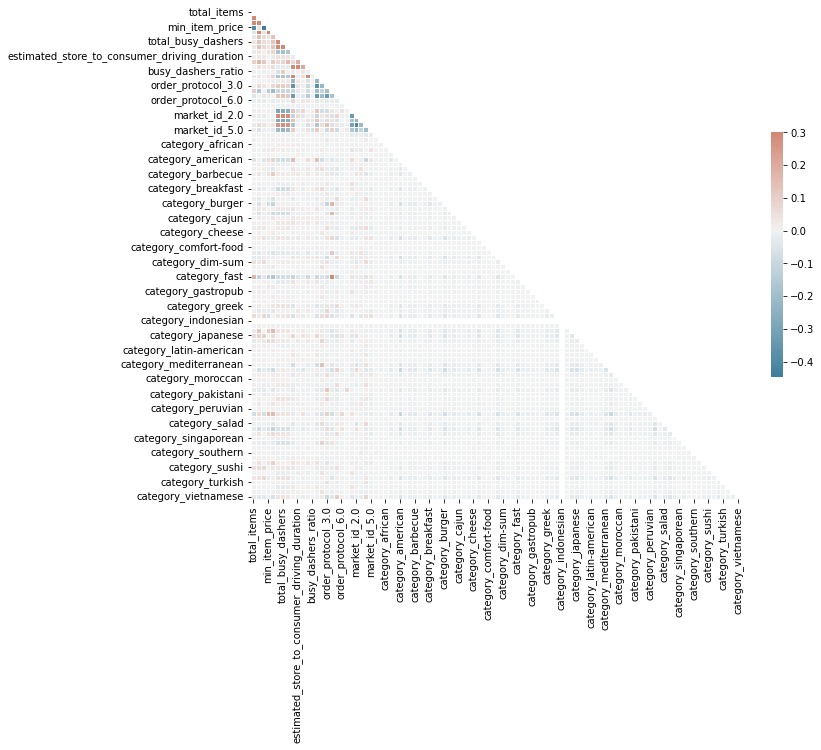

In [136]:
# it could take some time to run this cell since we are calculating correlation matrix in a dimesion of (100x100)
# to have a better visualization, we will take only one triangle 
# because other trangle is only its symmetry (i.e a x b and b x a)

# Generate a mask for the upper triangle
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

It seems there is a problem with `category_indonesian`. Check with _.describe( )_.

In [137]:
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

It has a zero std value. We can drop it. Let's see the top correlated features.

In [138]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489946
num_distinct_items          

We have highly correlated features. We can drop some columns based on how much its information could be captured by other features.Firstly, `total_busy_dashers` and `total_onshift_dashers` are actually represented by `busy_dashers_ratio`. We can drop them off. Secondly, `estimated_non_prep_duation` - we created this feature - is correlated with driving and order place duration. We can keep the original value and drop the created one. Additionally, market id values are also on the list as being correlated with each other. As same with all kinds of colliniearities, these are potential suspects to hurt the regression performance. We won't concat them into the dataframe anymore. Let's do it and check the correlations again.

In [144]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = historical_data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
# don't concat market id
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)
# drop highly correlated features
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers",
                                  "category_indonesian", 
                                  "estimated_non_prep_duration"])
# align dtype over dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
train_df.shape

(177070, 90)

In [145]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

It seems order protocols are also highly correlated with each other. We also won't concat them. Let's repeat the process one more time.

In [147]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = historical_data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
# don't concat order_protocol_dummies
train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers",
                                  "category_indonesian", 
                                  "estimated_non_prep_duration"])
# align dtype over dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
subtotal                                      actual_total_delivery_duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.17

Still, we have some features with high correlations. The total item number or distinct items could affect the duration of the preparation process. Therefore, we do not prefer to drop them. Instead, we can use the power of feature engineering. We will create new columns to infer the contribution of these columns.

In [149]:
# new features
train_df["percent_distinct_item_of_total"] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df.drop(columns=["num_distinct_items", "subtotal"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.17

We will apply a similar trick for min and max item prices.

In [150]:
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["max_item_price", "min_item_price"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      actual_total_delivery_duration    0.15

In [35]:
train_df.drop(columns=["subtotal"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.17

We solved the main issues with correlation. We are done with feature engineering now. We can officially apply a multicollinearity check in the next step. We reduced our number of columns to 82.

In [37]:
train_df.shape

(177070, 82)

## Multicollinearity check

We will check it through Variance Inflation Factor (VIF). We will eliminate all features that have VIF score above 20. For each iteration, we will drop only one feature, since when the feature set is changed VIF scores also change.

In [151]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [152]:
# compute VIF score with variance_inflation_factor() function
def compute_vif(features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

The running time of the next cell could be long, it is normal. It will calculate a VIF score for each column.

In [153]:
# apply VIF computation to all columns
features = train_df.drop(columns=["actual_total_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000370
1,category_chocolate,1.000489
2,category_belgian,1.000749
3,category_russian,1.003226
4,category_african,1.003821
...,...,...
76,busy_dashers_ratio,6.369593
77,category_american,7.033601
78,estimated_store_to_consumer_driving_duration,7.210811
79,estimated_order_place_duration,13.472028


We have a multicollinearity issue despite all our efforts in the feature engineering part. Next, we will drop the columns with the VIF score over the threshold. 

In [154]:
# drop with highest vif score until all vif scores are under 20
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data

I will remove percent_distinct_item_of_total


,feature,VIF
0,category_alcohol-plus-food,1.000222
1,category_chocolate,1.000362
2,category_belgian,1.000451
3,category_russian,1.002017
4,category_gluten-free,1.002364
...,...,...
75,category_american,4.505926
76,avg_price_per_item,5.958958
77,busy_dashers_ratio,6.357883
78,estimated_store_to_consumer_driving_duration,7.192610


It was enough to just drop `percent_distinct_item_of_total`. If you want to observe the effect of multicollinearity you can continue without dropping it and compare the results with dropped version.

# Feature Selection

We have a rich feature set. To reduce the noise in the model and decrease the training duration, we can use a subset of these features in the modeling part. Therefore, we will investigate the feature importances. First, we use RandomForestRegressor to get the importance of each feature in the prediction of the actual total delivery duration.

In [156]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# selected features are selected in multicollinearity check part
X = train_df[selected_features]
y = train_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

After fitting the model, let's sort all features based on their importance and visualize them.

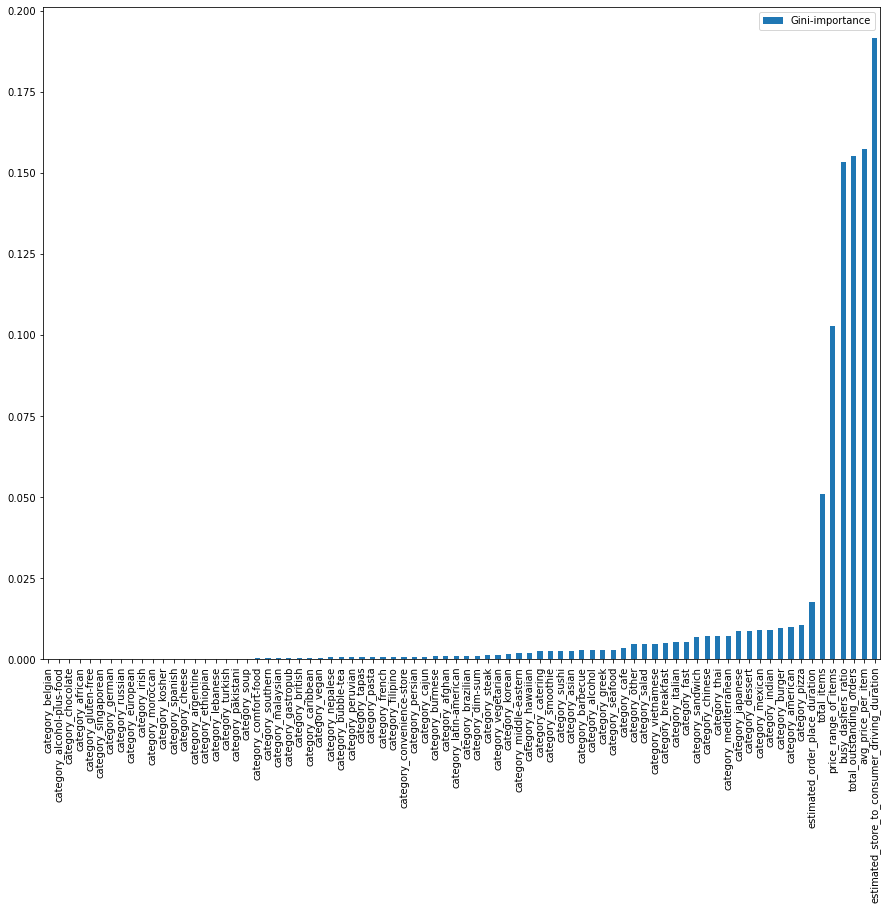

In [157]:
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

Many of the features have a very marginal contribution to regression. Let's check the most important ones.

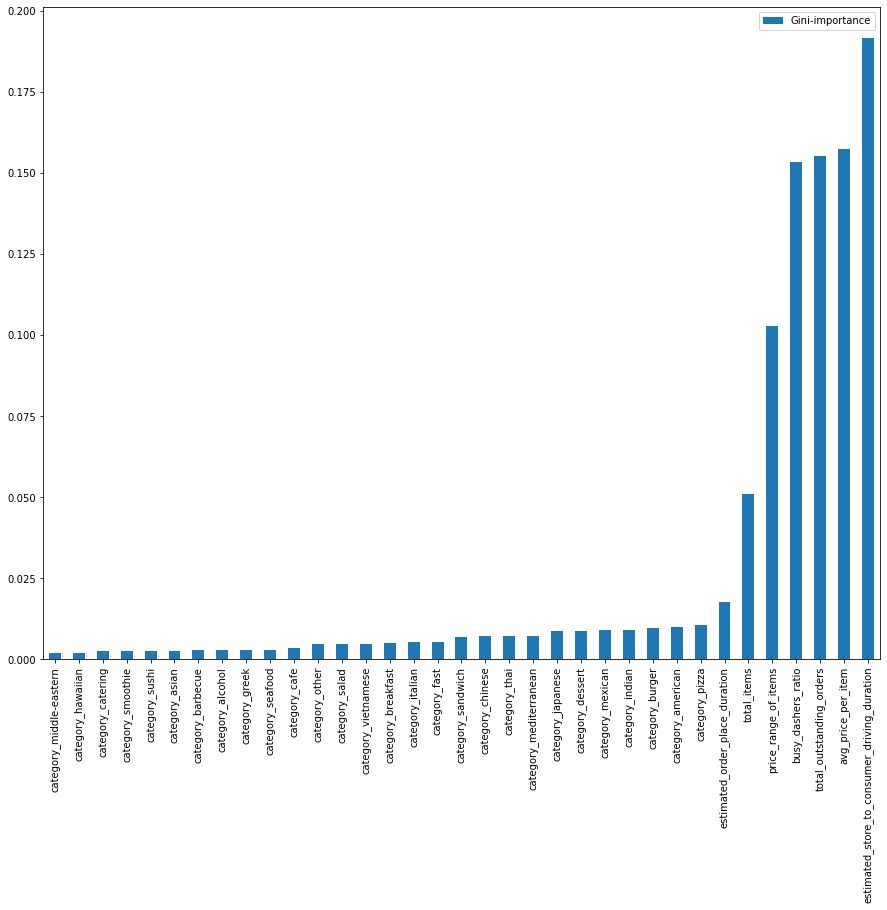

In [158]:
importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

As expected, estimated store-to-consumer driving duration is very important to overall delivery duration. Busy dashers ratio, total outstanding orders, and average price per item are also highly contributed features. We can choose our final features subset using these importances. 

In [45]:
importances

,Gini-importance
category_alcohol-plus-food,2.268982e-07
category_chocolate,3.558514e-07
category_belgian,1.432676e-07
category_russian,2.557240e-05
category_gluten-free,1.525806e-05
...,...
category_american,9.965093e-03
avg_price_per_item,1.574592e-01
busy_dashers_ratio,1.534591e-01
estimated_store_to_consumer_driving_duration,1.915803e-01


In [160]:
# we can obtain the column names as next
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

Another method to decrease feature dimension is PCA (Principal Component Analysis). It maps all features to another plain and obtains the most representative interpretations to explain all variances in the dataframe. 

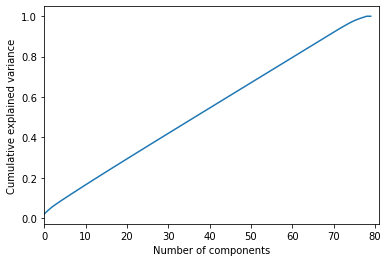

In [161]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

PCA shows that we need to use at least 60 representative features to explain 80% of the dataset, which makes the PCA transformation useless since we already have 80 and could select the most important ones based on feature importance. However, if PCA would tell us it can explain the majority of variance with around 10 features - high reduction - we would continue with it.

# Apply scaler

We are done with features. We move to modelling part. As we see in data exploration part, we have great differences between minimum and maximum values within the dataframe. It is a good motivation to use scaler for the sake of regression performance. We have different options to use as scaler. So, we implement a generic function that could use any sklearn scaler. We will use MinMaxScaler and StandardScaler to see if there is any performance difference between them for our dataframe.

In [162]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(scaler, X, y):
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [163]:
# example to show how to use it
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

In [164]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42)

# Inverse transform for metric comparison

Since we applied a scaler to training data, the predictions for test data will also be scaled. And to see the error in terms of seconds, we need to apply the inverse transformation. We will use Root Mean Squared Error to measure error. We could also use Mean Squared Error or Mean Absolute Error. We gave our decision based on the sensitivity of RMSE for high error terms. In our thought, the consumer patience with delaying delivery could decrease exponentially with time. The detailed comparison of MAE, MSE, and, RMSE could be found here: https://towardsdatascience.com/comparing-robustness-of-mae-mse-and-rmse-6d69da870828

In [165]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    # return RMSE with squared False     
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)
    
    return rmse_error, y_predict

# ML based regression

Since we have no prior knowledge about which regressor has the best performance with our problem, we will try several of them. Therefore, we implement a generic regression function below, which could work with different regression models.

In [166]:
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    model.fit(X_train,y_train)
    y_predict=model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict=model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=Fbalse)
    if verbose:
        print("Train error = "'{}'.format(train_error)+" in " + model_name)
        print("Test error = "'{}'.format(test_error)+" in " + model_name)
    trained_model = model
    
    return trained_model, y_predict, train_error, test_error

We will do an experiment with different regression models, feature sets, and scalers. We will store the error rate for each model in `pred_dict`. Then, we will plot and comment performance. It is necessary to see what works best for higher performance.

In [167]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}


regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}

feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(), 

    
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}


for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():   
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
            
            else:
                
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)


-----scaled with Standard scaler-------- included columns are full dataset

Error = 2053.69873046875 in Ridge
Error = 2057.2476687088733 in DecisionTree
Error = 2048.7870426727054 in RandomForest
Error = 2036.2498779296875 in XGBoost
Error = 2033.4355809987908 in LGBM
Error = 2037.1278076171875 in MLP
-----scaled with MinMax scaler-------- included columns are full dataset

Error = 2053.962890625 in Ridge
Error = 2057.2476685732177 in DecisionTree
Error = 2047.5969635772415 in RandomForest
Error = 2036.561279296875 in XGBoost
Error = 2034.4499976619875 in LGBM
Error = 2162.84130859375 in MLP
-----scaled with NotScale-------- included columns are full dataset

Train error = 1071.4971923828125 in Ridge
Test error = 2053.6923828125 in Ridge


/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.42546e-11): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1067.7815291116704 in DecisionTree
Test error = 2057.2476684096064 in DecisionTree
Train error = 396.512251688704 in RandomForest
Test error = 2047.9396170749237 in RandomForest


/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Train error = 968.2471313476562 in XGBoost
Test error = 2036.43212890625 in XGBoost
Train error = 1017.5549840201221 in LGBM
Test error = 2034.461097275308 in LGBM


/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1055.87890625 in MLP
Test error = 2047.0823974609375 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2054.00439453125 in Ridge
Error = 2056.5292024696128 in DecisionTree
Error = 2048.7404898481154 in RandomForest
Error = 2035.453369140625 in XGBoost
Error = 2034.6538984910121 in LGBM
Error = 2036.5350341796875 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_40

Error = 2054.27734375 in Ridge
Error = 2056.5292023632996 in DecisionTree
Error = 2047.6789758344682 in RandomForest
Error = 2036.3470458984375 in XGBoost
Error = 2035.196536738781 in LGBM
Error = 2289.329345703125 in MLP
-----scaled with NotScale-------- included columns are selected_features_40

Train error = 1072.35498046875 in Ridge
Test error = 2054.00439453125 in Ridge


/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.55928e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1067.785563647774 in DecisionTree
Test error = 2056.529202224364 in DecisionTree
Train error = 397.5520444669267 in RandomForest
Test error = 2048.941396368513 in RandomForest


/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Train error = 965.6858520507812 in XGBoost
Test error = 2035.7642822265625 in XGBoost
Train error = 1017.1430421117441 in LGBM
Test error = 2034.8058530174258 in LGBM


/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1060.465087890625 in MLP
Test error = 2049.227783203125 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_20

Error = 2055.36572265625 in Ridge
Error = 2054.610311207463 in DecisionTree
Error = 2048.928270457714 in RandomForest
Error = 2037.6336669921875 in XGBoost
Error = 2036.0233846729805 in LGBM
Error = 2036.5887451171875 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_20

Error = 2055.653076171875 in Ridge
Error = 2054.6103112689557 in DecisionTree
Error = 2048.937604214675 in RandomForest
Error = 2037.1251220703125 in XGBoost
Error = 2035.581516471472 in LGBM
Error = 2100.1201171875 in MLP
-----scaled with NotScale-------- included columns are selected_features_20

Train error = 1074.506591796875 in Ridge
Test error = 2055.365478515625 in Ridge


/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.43865e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1069.1350906055598 in DecisionTree
Test error = 2054.610311170708 in DecisionTree
Train error = 397.7565059265296 in RandomForest
Test error = 2050.236769249936 in RandomForest


/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Train error = 966.1651000976562 in XGBoost
Test error = 2036.249267578125 in XGBoost
Train error = 1018.9600610110249 in LGBM
Test error = 2035.9494403356318 in LGBM
Train error = 1058.29296875 in MLP
Test error = 2049.770263671875 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_10

Error = 2056.568359375 in Ridge
Error = 2054.5971761770547 in DecisionTree
Error = 2052.4825688447004 in RandomForest
Error = 2040.27001953125 in XGBoost
Error = 2038.1313604554389 in LGBM
Error = 2041.403564453125 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_10

Error = 2056.882080078125 in Ridge
Error = 2054.5971762373274 in DecisionTree
Error = 2051.561062644295 in RandomForest
Error = 2039.672119140625 in XGBoost
Error = 2037.6564489201091 in LGBM
Error = 2066.84130859375 in MLP
-----scaled with NotScale-------- included columns are selected_features_10

Train error = 1076.7279052734375 in Ridge
Test error = 2056.568359375 in

/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Train error = 976.43798828125 in XGBoost
Test error = 2039.2135009765625 in XGBoost
Train error = 1022.939378192528 in LGBM
Test error = 2038.4873761329577 in LGBM
Train error = 1067.5985107421875 in MLP
Test error = 2055.416259765625 in MLP


In [168]:
pred_df = pd.DataFrame(pred_dict)

In [169]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard scaler,2053.698730
1,DecisionTree,full dataset,Standard scaler,2057.247669
2,RandomForest,full dataset,Standard scaler,2048.787043
3,XGBoost,full dataset,Standard scaler,2036.249878
4,LGBM,full dataset,Standard scaler,2033.435581
...,...,...,...,...
67,DecisionTree,selected_features_10,NotScale,2066.841309
68,RandomForest,selected_features_10,NotScale,2066.841309
69,XGBoost,selected_features_10,NotScale,2066.841309
70,LGBM,selected_features_10,NotScale,2066.841309


<AxesSubplot:>

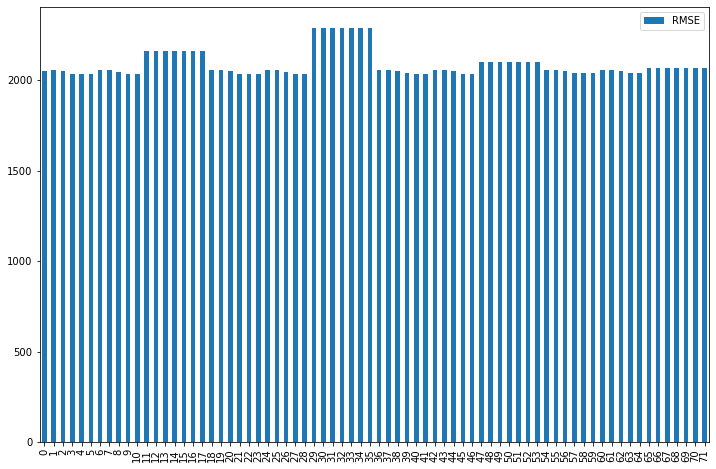

In [170]:
pred_df.plot(kind='bar', figsize=(12,8))

It seems we have high errors through all models. Also, the models inform us to not scale affects the performance. We could pick one of the scalers and continue since it doesn't affect the performance much. The decrease in training feature size first slightly improves the performance and then marginally made it worse. We choose to use 40 as a final decision. When we examine the model performances, the most significant thing is the error rates. What we could do more to improve it? Could it be our dataset is not a good representative for estimating the total delivery duration? One idea could be predicting preparation time and using the given estimated store-to-consumer driving ratio and order place, to sum up, and find the total delivery duration. Let's try it.

In [171]:
# change the problem a bit
train_df["prep_time"] = train_df["actual_total_delivery_duration"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]

# not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)
        

-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2055.40771484375 in Ridge
Error = 2045.9600605629953 in DecisionTree
Error = 2052.368279418553 in RandomForest
Error = 2037.8203125 in XGBoost
Error = 2035.7236370573405 in LGBM
Error = 2038.763916015625 in MLP


LGBM consistently performs best. Choose best perform model and extract the predictions for preparation duration

In [177]:
# not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

regression_models = {
    "LGBM": LGBMRegressor(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)
   

-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2035.7236370573405 in LGBM


In [178]:
# choose best perform model and extract the predictions for preparation duration
pred_values_dict = {
    "actual_total_delivery_duration": train_df["actual_total_delivery_duration"][test_indices].values.tolist(), 
    "prep_duration_prediction":y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),             
}


In [179]:
# convert it to dataframe from dict
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1734.115287,380.0,251.0
1,1839.0,1508.588146,747.0,446.0
2,1927.0,2141.085685,543.0,251.0
3,2657.0,1312.559865,445.0,251.0
4,3596.0,1945.871826,691.0,446.0
...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0
35410,1864.0,2148.159250,324.0,446.0
35411,2674.0,1939.286320,791.0,251.0
35412,2234.0,1930.656157,687.0,251.0


We obtained the predictions for the preparation duration of each order. Now, we can sum it up with non preparation activities such as order placing and driving.

In [180]:
values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"] + values_df["estimated_order_place_duration"]
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1734.115287,380.0,251.0,2365.115287
1,1839.0,1508.588146,747.0,446.0,2701.588146
2,1927.0,2141.085685,543.0,251.0,2935.085685
3,2657.0,1312.559865,445.0,251.0,2008.559865
4,3596.0,1945.871826,691.0,446.0,3082.871826
...,...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0,3837.132706
35410,1864.0,2148.159250,324.0,446.0,2918.159250
35411,2674.0,1939.286320,791.0,251.0,2981.286320
35412,2234.0,1930.656157,687.0,251.0,2868.656157


Let's check if the error rate is better after changing the approach.

In [181]:
mean_squared_error(values_df["actual_total_delivery_duration"], values_df["sum_total_delivery_duration"], squared=False)

2035.7236370573405

It is not better and very close to the previous error. What if we use another regression to obtain the actual total delivery duration using preparation duration prediction, estimated store to consumer driving duration, and order place duration? Would it be a solution? 

In [182]:
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [183]:
regression_models = {
    "LinearReg" : linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(
        X_train, y_train, X_test, y_test,regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, mean_squared_error(y_test,y_predict, squared=False))

RMSE of: LinearReg 986.6912510303845
RMSE of: Ridge 986.6912510344928
RMSE of: DecisionTree 1235.578088153976
RMSE of: RandomForest 1406.5028487897564


/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/busesibelkorkmaz/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE of: XGBoost 1370.412425918564
RMSE of: LGBM 1079.2949179771774
RMSE of: MLP 987.2098861899121


Yes, this approach has better performance! We can choose this one as our official solution.

# Deep learning based regression

Could Artificial Neural Networks have a better performance for the given problem? The first intuition is that MLP performance was not better than tree-based regression in the preparation duration prediction part. Hence, we doubt it. However, MLP has a good performance on the prediction of actual total delivery using preparation, driving, and order place duration. Let's give it a try for this one!

In [184]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow import set_random_seed
set_random_seed(42)

# Neural network
def create_model(feature_set_size):
    
    # define the model
    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # compile the model
    model.compile(optimizer='sgd', loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [185]:
print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
print("")
model_name = "ANN"   
scaler_name = "Standard scaler"
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)
print("feature_set_size:",X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)


-----scaled with Standard scaler-------- included columns are selected_features_40

feature_set_size: 3
Epoch 1/100
159/443 [=========>....................] - ETA: 0s - loss: 0.2410 - root_mean_squared_error: 0.4909 

2022-05-28 17:54:11.561887: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


443/443 [==============================] - 0s 301us/step - loss: 1.1298 - root_mean_squared_error: 1.0629
Epoch 2/100
443/443 [==============================] - 0s 283us/step - loss: 1.1188 - root_mean_squared_error: 1.0577
Epoch 3/100
443/443 [==============================] - 0s 285us/step - loss: 1.1185 - root_mean_squared_error: 1.0576
Epoch 4/100
443/443 [==============================] - 0s 284us/step - loss: 1.1180 - root_mean_squared_error: 1.0574
Epoch 5/100
443/443 [==============================] - 0s 289us/step - loss: 1.1182 - root_mean_squared_error: 1.0575
Epoch 6/100
443/443 [==============================] - 0s 287us/step - loss: 1.1181 - root_mean_squared_error: 1.0574
Epoch 7/100
443/443 [==============================] - 0s 287us/step - loss: 1.1180 - root_mean_squared_error: 1.0574
Epoch 8/100
443/443 [==============================] - 0s 290us/step - loss: 1.1180 - root_mean_squared_error: 1.0574
Epoch 9/100
443/443 [==============================] - 0s 299us/step

443/443 [==============================] - 0s 290us/step - loss: 1.1169 - root_mean_squared_error: 1.0568
Epoch 71/100
443/443 [==============================] - 0s 284us/step - loss: 1.1171 - root_mean_squared_error: 1.0569
Epoch 72/100
443/443 [==============================] - 0s 283us/step - loss: 1.1172 - root_mean_squared_error: 1.0570
Epoch 73/100
443/443 [==============================] - 0s 302us/step - loss: 1.1172 - root_mean_squared_error: 1.0570
Epoch 74/100
443/443 [==============================] - 0s 294us/step - loss: 1.1170 - root_mean_squared_error: 1.0569
Epoch 75/100
443/443 [==============================] - 0s 289us/step - loss: 1.1173 - root_mean_squared_error: 1.0570
Epoch 76/100
443/443 [==============================] - 0s 282us/step - loss: 1.1171 - root_mean_squared_error: 1.0570
Epoch 77/100
443/443 [==============================] - 0s 286us/step - loss: 1.1168 - root_mean_squared_error: 1.0568
Epoch 78/100
443/443 [==============================] - 0s 28

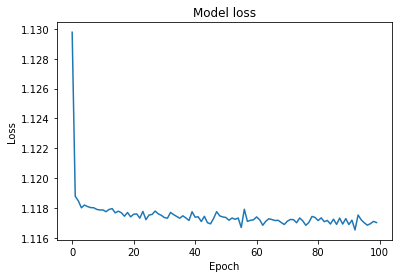

In [186]:
plt.plot(history.history['loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.show()

We achieved the same performance with the MLP method of sklearn. It could be possible to improve the performance a bit more with hyperparameter tuning in ANN, however,  it requires considerable time and effort. Would it be a better approach when we already have a good performance Linear Regression model which is very simple and fast? It is a design choice. We leave our official solution as LGBM + Linear Regression on top. 